### Import python libraries

In [2]:
!pip install mysql-connector-python

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
import mysql.connector

con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

### Load SQL queries

In [9]:
imdb_title_crew_df = pd.read_sql_query("""
SELECT * 
FROM movies.imdb_title_crew;
""",con)

In [10]:
imdb_title = pd.read_sql_query("""
SELECT * 
FROM movies.imdb_title_basics;
""",con)

In [11]:
imdb_people = pd.read_sql_query("""
SELECT * 
FROM movies.imdb_name_basics;
""",con)

In [12]:
imdb_ratings = pd.read_sql_query("""
SELECT 
	tconst,
    averagerating,
    numvotes
FROM movies.imdb_title_ratings
""",con)

## Analysis

First of all, we combine SQL tables and manipulate the data so that we have all relevant information in seperate columns of one table. Relevant information includes movie title, movie rating, director names.

In [13]:
# One column per each director identifier
imdb_test = imdb_title_crew_df['directors'].str.split(pat=',',expand=True)

In [14]:
imdb_test.iloc[ : ,1].isna().sum() 
# Out of 146144 movies, 130417 have only 1 director 

130417

In [15]:
# Add movie identifier to table
imdb_test['tconst'] = imdb_title_crew_df['tconst']

In [16]:
# Drop irrelevant columns
imdb_test = imdb_test.drop(imdb_test.iloc[:,3:26], axis = 1)

In [17]:
# Rename table columns
imdb_title_crew_df['dir1'] = imdb_test[0]
imdb_title_crew_df['dir2'] = imdb_test[1]
imdb_title_crew_df['dir3'] = imdb_test[2]

In [18]:
# Rename table to something shorter
imdb_crew = imdb_title_crew_df

In [19]:
# One column per each writer identifier
writers = imdb_title_crew_df['writers'].str.split(pat=',',expand=True)

In [20]:
writers.iloc[:,3].isna().sum() 
# Out of 146144 movies, 140714 have only max 3 writers 

140714

In [21]:
# Rename table columns
imdb_crew['wri1'] = writers[0]
imdb_crew['wri2'] = writers[1]
imdb_crew['wri3'] = writers[2]

In [22]:
# Add director and writer names to the table
imdb = imdb_title.set_index('tconst').join(imdb_crew.set_index('tconst'))

In [23]:
nconst_to_names = imdb_people.loc[:, ['nconst','primary_name']]

In [24]:
imdb = imdb.join(nconst_to_names.set_index('nconst'),
          on='dir1',
          rsuffix='_names')

In [25]:
imdb = imdb.rename(columns={'primary_name':'dir1_name'})

In [26]:
imdb = imdb.join(nconst_to_names.set_index('nconst'),
          on='dir2',
          rsuffix='_names')

In [27]:
imdb = imdb.rename(columns={'primary_name':'dir2_name'})

In [28]:
imdb = imdb.join(nconst_to_names.set_index('nconst'),
          on='dir3',
          rsuffix='_names')

In [29]:
imdb = imdb.rename(columns={'primary_name':'dir3_name'})

In [30]:
imdb = imdb.join(nconst_to_names.set_index('nconst'),
          on='wri1',
          rsuffix='_names')

In [31]:
imdb = imdb.rename(columns={'primary_name':'wri1_name'})

In [32]:
imdb = imdb.join(nconst_to_names.set_index('nconst'),
          on='wri2',
          rsuffix='_names')

In [33]:
imdb = imdb.rename(columns={'primary_name':'wri2_name'})

In [34]:
imdb = imdb.join(nconst_to_names.set_index('nconst'),
          on='wri3',
          rsuffix='_names')

In [35]:
imdb = imdb.rename(columns={'primary_name':'wri3_name'})

In [36]:
imdb = imdb.reset_index()

In [37]:
# Add ratings to the table
imdb = imdb.join(imdb_ratings.set_index('tconst'),
          on='tconst',
          rsuffix='_ratings')

In [38]:
# One genre per column 
imdb[['genre1','genre2','genre3']] = imdb['genres'].str.split(pat=',',expand=True)

In [39]:
imdb['genre3'].isna().sum()

116708

In [40]:
imdb.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,directors,writers,dir1,dir2,...,dir2_name,dir3_name,wri1_name,wri2_name,wri3_name,averagerating,numvotes,genre1,genre2,genre3
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",nm0712540,"nm0023551,nm1194313,nm0347899,nm1391276",nm0712540,None,...,NaN,NaN,Abrar Alvi,Mahasweta Devi,Gulzar,7.0,77.0,Action,Crime,Drama
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",nm0002411,None,nm0002411,None,...,NaN,NaN,NaN,NaN,NaN,7.2,43.0,Biography,Drama,None
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,nm0000080,"nm0000080,nm0462648",nm0000080,None,...,NaN,NaN,Orson Welles,Oja Kodar,NaN,6.9,4517.0,Drama,None,None
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",nm0611531,nm0347899,nm0611531,None,...,NaN,NaN,Gulzar,NaN,NaN,6.1,13.0,Comedy,Drama,None
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy","nm0765384,nm0749914","nm1360635,nm0749914",nm0765384,nm0749914,...,Raoul Ruiz,NaN,Pía Rey,Raoul Ruiz,NaN,6.5,119.0,Comedy,Drama,Fantasy


### Chart 1: Directors with most movies with ratings above 7.5 (median is 6.1 with 1.35 std) since 2010 with at least 100 votes

In [41]:
chart1data1 = imdb.sort_values(by='averagerating',ascending = False).loc[(imdb['averagerating'].notna()) & (imdb['numvotes']>100)]

In [42]:
chart1data2 = chart1data1.sort_values(by='averagerating',ascending = False).loc[imdb['averagerating'] > 7.5]

In [43]:
chart1data3 = chart1data2.groupby('dir1_name').count().sort_values(by='tconst',ascending = False)

In [44]:
chart1data4 = chart1data3.loc[chart1data3['tconst'] > 3]['tconst']

In [45]:
chart1data4

dir1_name
Paul Dugdale           6
Kaushik Ganguly        5
Denis Villeneuve       5
Alex Gibney            4
Keitarô Motonaga       4
Tim Van Someren        4
Anurag Singh           4
Shunsuke Tada          4
Shoojit Sircar         4
Christopher Nolan      4
Anthony Russo          4
Quentin Tarantino      4
Ram Gopal Varma        4
Aris Chatzistefanou    4
Martin Scorsese        4
Name: tconst, dtype: int64

Text(0.5, 1.0, 'Directors with most movies with 7.5+ ratings')

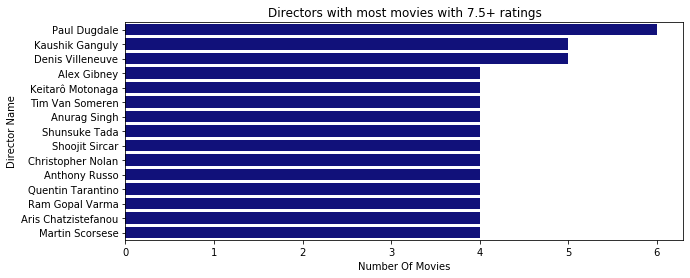

In [169]:
fig, chart1 = plt.subplots()
fig.set_size_inches(10, 4)
chart1index = list(chart1data4.index)
chart1values = list(chart1data4)
chart1 = sns.barplot(x=chart1values, 
                     y=chart1index,
                     color='darkblue')
chart1.set(ylabel='Director Name', xlabel='Number Of Movies')
chart1.set_title('Directors with most movies with 7.5+ ratings')

### Ratings By Genre

In [66]:
rgdata1 = imdb[['genre1','averagerating','start_year','numvotes']].loc[imdb['genre1'].notna()]

In [67]:
rgdata1 = rgdata1.rename(columns={'genre1':'genre'})

In [68]:
rgdata2 = imdb[['genre2','averagerating','start_year','numvotes']].loc[imdb['genre2'].notna()]

In [69]:
rgdata2 = rgdata2.rename(columns={'genre2':'genre'})

In [83]:
rgdata3 = imdb[['genre3','averagerating','start_year','numvotes']].loc[imdb['genre3'].notna()]

In [72]:
rgdata3 = rgdata3.rename(columns={'genre3':'genre'})

In [73]:
rgdata4 = pd.concat([rgdata1, rgdata2, rgdata3])

In [80]:
rgdata5 = rgdata4[['genre','averagerating','start_year','numvotes']].loc[rgdata4['averagerating'].notna()]

In [81]:
rgdata6 = rgdata5.loc[rgdata5['numvotes']>100]

### Chart 2: Genres of Movies With Ratings of 8.0+ 

In [88]:
#rgdata6 = one row per genre, movies with at least 100 numvotes and no 'averagerating' N/A, since 2010
chart2data1 = rgdata6.sort_values('averagerating', ascending=False)

In [89]:
chart2data1 = chart2data1.loc[chart2data1['averagerating'] > 8]

In [90]:
chart2data1 = chart2data1.groupby('genre').count()['averagerating'].nlargest(10)

Text(0.5, 1.0, 'Movies With 8.0+ Ratings')

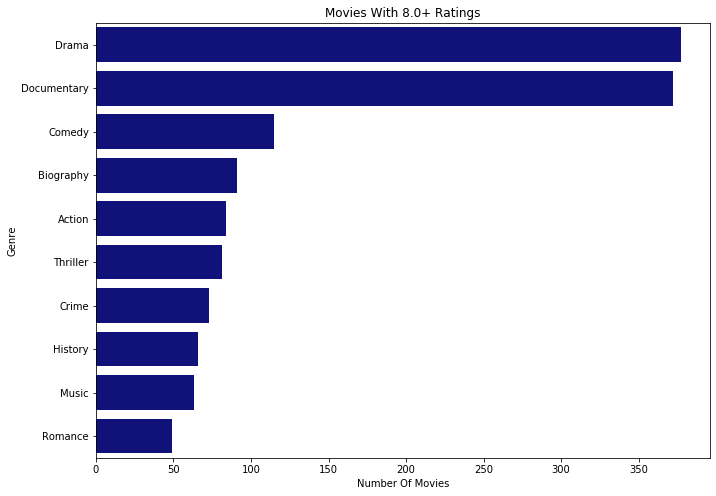

In [156]:
fig, chart2 = plt.subplots()
fig.set_size_inches(11, 8)
chart2ylabel = list(chart2data1.index)
chart2values = list(chart2data1)
chart2 = sns.barplot(x=chart2values, 
                     y=chart2ylabel,
                     color='darkblue')
chart2.set(ylabel='Genre', xlabel='Number Of Movies')
chart2.set_title('Movies With 8.0+ Ratings')

### Chart 3: Movie Rating Mean, Median, Volatility

In [92]:
#rgdata6 = one row per genre, movies with at least 100 numvotes and no 'averagerating' N/A, since 2010

In [93]:
chart3data1 = rgdata6.groupby('genre').describe()

In [94]:
chart3data1.drop(chart3data1.columns[8:],axis=1,inplace=True)

In [95]:
chart3data2 = chart3data1.loc[chart3data1['averagerating', 'count'] > 250]

In [97]:
chart3data2 = chart3data2.sort_values(by=('averagerating', '50%'),ascending=False)

In [98]:
chart3data2.head(10).index

Index(['Documentary', 'Biography', 'Music', 'Sport', 'History', 'War',
       'Animation', 'Drama', 'Crime', 'Family'],
      dtype='object', name='genre')

In [99]:
# Manually select the top 10 Median genres
Top10Median = list(chart3data2.head(10).index)

In [105]:
chart3data3 = rgdata6.loc[chart2data6['genre'].isin(Top10Median)]

In [106]:
chart3data4 = chart3data3[['genre','averagerating']]

In [147]:
char3data4index = chart3data4.groupby('genre').median().sort_values(by='averagerating',ascending=False).index

Text(0.5, 1.0, 'Ratings by Genre')

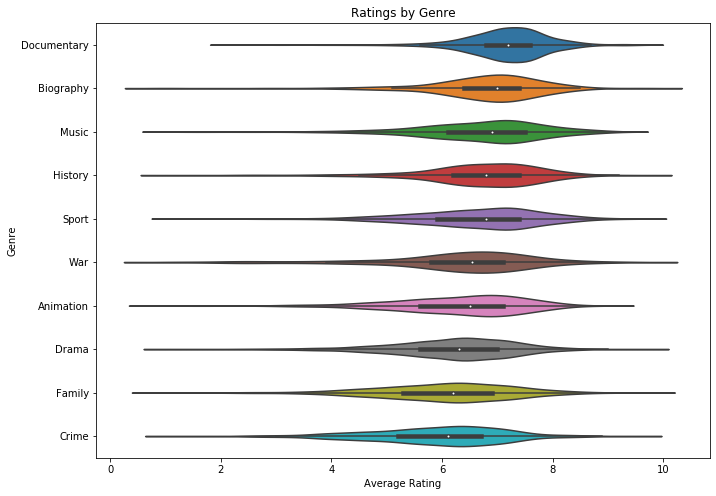

In [155]:
fig, chart3 = plt.subplots()
fig.set_size_inches(11, 8)
chart3 = sns.violinplot(x="averagerating", 
                    y="genre", 
                    data=chart3data4,
                    order=char3data4index)
chart3.set(ylabel='Genre', xlabel='Average Rating')
chart3.set_title('Ratings by Genre')